## Deteksi Karakter Plat Nomor Kendaraan

In [1]:
# Wawan Setiawan
# Universitas Sangga Buana

import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import os
import tensorflow as tf
from tensorflow import keras
import imutils

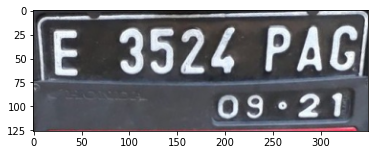

In [2]:
img = cv.imread(r'D:\Tugas_Kelompok\deteksi_platnomor\static\images\results\crops\plat hitam\tesnopol.jpeg')
img = imutils.resize(img, width=350)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img)

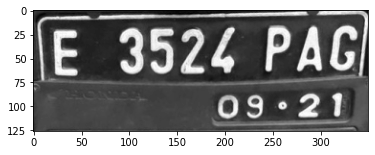

In [3]:
# convert bgr to grayscale
img_plate_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
plt.imshow(img_plate_gray, cmap='gray')

In [4]:
# karakter yang akan disegmentasi adalah baris pertama nomor kendaraan

# konversi dari grayscale ke BW
(thresh, img_plate_bw) = cv.threshold(img_plate_gray, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

In [5]:
# maka hilangkan area yang tidak diinginkan dengan operasi opening

# buat kernel dengan bentuk cross dan ukuran 3x3
kernel = cv.getStructuringElement(cv.MORPH_CROSS, (3,3))

Text(0.5, 1.0, 'sebelum open')

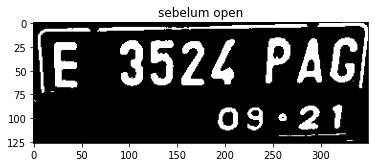

In [6]:
plt.imshow(cv.cvtColor(img_plate_bw, cv.COLOR_BGR2RGB))
plt.title("sebelum open")

In [7]:
# lakukan operasi opening dengan kernel di atas
# apply morph open
img_plate_bw = cv.morphologyEx(img_plate_bw, cv.MORPH_OPEN, kernel)

Text(0.5, 1.0, 'sesudah open')

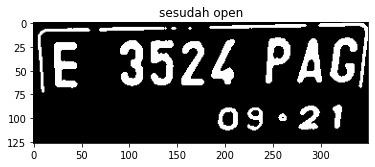

In [8]:
plt.imshow(cv.cvtColor(img_plate_bw, cv.COLOR_BGR2RGB))
plt.title("sesudah open")

## Segmentasi Karakter Menggunakan Contours

In [9]:
# dapatkan kontur dari plat nomor
contours_plate, hierarchy = cv.findContours(img_plate_bw, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE) 

# index contour yang berisi kandidat karakter
index_chars_candidate = []

# index counter dari setiap contour di contours_plate
index_counter_contour_plate = 0

# duplikat dan ubah citra plat dari gray dan bw ke rgb untuk menampilkan kotak karakter
img_plate_rgb = cv.cvtColor(img_plate_gray,cv.COLOR_GRAY2RGB)
img_plate_bw_rgb = cv.cvtColor(img_plate_bw, cv.COLOR_GRAY2RGB)

# Mencari kandidat karakter
for contour_plate in contours_plate:

    # dapatkan lokasi x, y, nilai width, height dari setiap kontur plat
    x_char,y_char,w_char,h_char = cv.boundingRect(contour_plate)
    
    # Dapatkan kandidat karakter jika:
    #   tinggi kontur dalam rentang 40 - 60 piksel
    #   dan lebarnya lebih dari atau sama dengan 10 piksel 
    if h_char >= 40 and h_char <= 60 and w_char >=10:

        # dapatkan index kandidat karakternya
        index_chars_candidate.append(index_counter_contour_plate)

        # gambar kotak untuk menandai kandidat karakter
        cv.rectangle(img_plate_rgb,(x_char,y_char),(x_char+w_char,y_char+h_char),(0,255,0),2)
        cv.rectangle(img_plate_bw_rgb,(x_char,y_char),(x_char+w_char,y_char+h_char),(0,255,0),2)

    index_counter_contour_plate += 1

Text(0.5, 1.0, 'Kandidat Karakter')

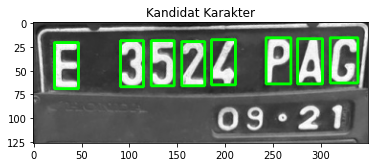

In [10]:
# tampilkan kandidat karakter
plt.imshow(cv.cvtColor(img_plate_rgb, cv.COLOR_BGR2RGB))
plt.title("Kandidat Karakter")

In [11]:
if index_chars_candidate == []:

    # tampilkan informasi apabila tidak ada kandidat karakter
    print('Karakter tidak tersegmentasi')
else:
    print('Proses Karakter tersegmentasi')

Proses Karakter tersegmentasi


# Scoring

In [12]:
score_chars_candidate = np.zeros(len(index_chars_candidate))

# untuk counter index karakter
counter_index_chars_candidate = 0

# bandingkan lokasi y setiap kandidat satu dengan kandidat lainnya
for chars_candidateA in index_chars_candidate:
        
    # dapatkan nilai y dari kandidat A
    xA,yA,wA,hA = cv.boundingRect(contours_plate[chars_candidateA])
    for chars_candidateB in index_chars_candidate:

        # jika kandidat yang dibandikan sama maka lewati
        if chars_candidateA == chars_candidateB:
            continue
        else:
            # dapatkan nilai y dari kandidat B
            xB,yB,wB,hB = cv.boundingRect(contours_plate[chars_candidateB])

            # cari selisih nilai y kandidat A dan kandidat B
            y_difference = abs(yA - yB)

            # jika perbedaannya kurang dari 15 piksel
            if y_difference < 15:
                    
                # tambahkan nilai score pada kandidat tersebut
                score_chars_candidate[counter_index_chars_candidate] = score_chars_candidate[counter_index_chars_candidate] + 1 

    # lanjut ke kandidat lain
    counter_index_chars_candidate += 1

print(score_chars_candidate)

[7. 7. 7. 7. 7. 7. 7. 7.]


In [13]:
# untuk menyimpan karakter
index_chars = []

# counter karakter
chars_counter = 0

# dapatkan karakter, yaitu yang memiliki score tertinggi
for score in score_chars_candidate:
    if score == max(score_chars_candidate):

        # simpan yang benar-benar karakter
        index_chars.append(index_chars_candidate[chars_counter])
    chars_counter += 1

# duplikat dan ubah ke rgb untuk menampilkan urutan karakter yang belum terurut
img_plate_rgb2 = cv.cvtColor(img_plate_gray, cv.COLOR_GRAY2BGR)

In [14]:
# tampilkan urutan karakter yang belum terurut
for char in index_chars:
    x, y, w, h = cv.boundingRect(contours_plate[char])
    cv.rectangle(img_plate_rgb2,(x,y),(x+w,y+h),(0,255,0),2)
    cv.putText(img_plate_rgb2, str(index_chars.index(char)),(x, y + h + 25), cv.FONT_ITALIC, 1.0, (0,0,255), 2)

Text(0.5, 1.0, 'Karakter Belum Terurut')

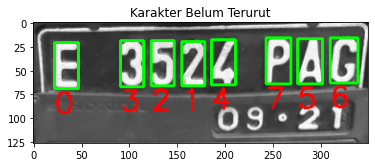

In [15]:
# tampilkan karakter yang belum terurut
plt.imshow(cv.cvtColor(img_plate_rgb2, cv.COLOR_BGR2RGB))
plt.title("Karakter Belum Terurut")

In [16]:
# Mulai mengurutkan

# untuk menyimpan koordinat x setiap karakter
x_coors = []

for char in index_chars:
    # dapatkan nilai x
    x, y, w, h = cv.boundingRect(contours_plate[char])

    # dapatkan nilai sumbu x
    x_coors.append(x)

# urutkan sumbu x dari terkecil ke terbesar
x_coors = sorted(x_coors)

# untuk menyimpan karakter
index_chars_sorted = []

# urutkan karakternya berdasarkan koordinat x yang sudah diurutkan
for x_coor in x_coors:
    for char in index_chars:

        # dapatkan nilai koordinat x karakter
        x, y, w, h = cv.boundingRect(contours_plate[char])

        # jika koordinat x terurut sama dengan koordinat x pada karakter
        if x_coors[x_coors.index(x_coor)] == x:

            # masukkan karakternya ke var baru agar mengurut dari kiri ke kanan
            index_chars_sorted.append(char)

# duplikat dan ubah ke rgb untuk menampilkan yang benar-benar karakter
img_plate_rgb3 = cv.cvtColor(img_plate_gray, cv.COLOR_GRAY2BGR)

# Gambar kotak untuk menandai karakter yang terurut dan tambahkan teks urutannya
for char_sorted in index_chars_sorted:

    # dapatkan nilai x, y, w, h dari karakter terurut
    x,y,w,h = cv.boundingRect(contours_plate[char_sorted])

    # gambar kotak yang menandai karakter terurut
    cv.rectangle(img_plate_rgb3,(x,y),(x+w,y+h),(0,255,0),2)

    # tambahkan teks urutan karakternya
    cv.putText(img_plate_rgb3, str(index_chars_sorted.index(char_sorted)),(x, y + h + 25), cv.FONT_ITALIC, 1.0, (0,0,255), 2)

In [ ]:
# tampilkan hasil pengurutan
plt.imshow(cv.cvtColor(img_plate_rgb3, cv.COLOR_BGR2RGB))
plt.title("Karakter Terurut")

## Klasifikasi Karakter

In [17]:
# https://www.tensorflow.org/tutorials/images/classification

# tinggi dan lebar citra untuk test
img_height = 40 
img_width = 40

# klas karakter
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

# load model yang sudah terlatih
model = keras.models.load_model('models/weights/keras')

In [19]:
# untuk menyimpan string karakter
num_plate = []

for char_sorted in index_chars_sorted:
    x,y,w,h = cv.boundingRect(contours_plate[char_sorted])

    # potong citra karakter
    char_crop = cv.cvtColor(img_plate_bw[y:y+h,x:x+w], cv.COLOR_GRAY2BGR)

    # resize citra karakternya
    char_crop = cv.resize(char_crop, (img_width, img_height))
        
#     preprocessing citra ke numpy array
    img_array = keras.preprocessing.image.img_to_array(char_crop)

#     agar shape menjadi [1, h, w, channels]
    img_array = tf.expand_dims(img_array, 0)

    # buat prediksi
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0]) 

    num_plate.append(class_names[np.argmax(score)])

Text(0.5, 1.0, 'E3524PAG')

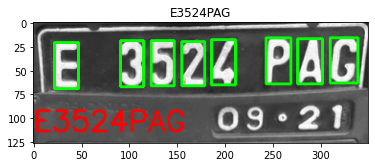

In [20]:
# Gabungkan string pada list
plate_number = ''
for a in num_plate:
    plate_number += a

# Hasil deteksi dan pembacaan

cv.putText(img_plate_rgb, plate_number,(0, y + h + 50), cv.FONT_ITALIC, 1.0, (0,0,255), 2)
plt.imshow(cv.cvtColor(img_plate_rgb, cv.COLOR_BGR2RGB))

plt.title(plate_number)

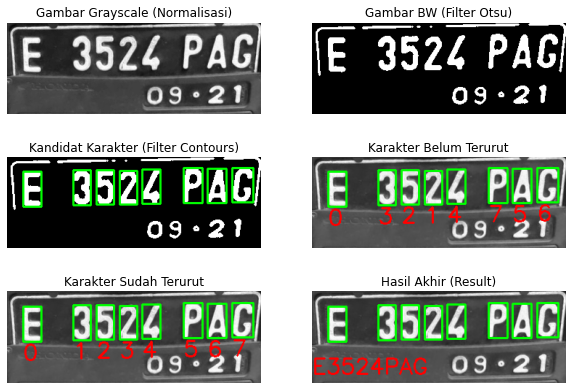

In [21]:
fig = plt.figure(figsize=(10, 7)) 
row_fig = 3
column_fig = 2

fig.add_subplot(row_fig, column_fig, 1)
plt.imshow(img_plate_gray, cmap="gray")
plt.axis('off')
plt.title("Gambar Grayscale (Normalisasi)")

fig.add_subplot(row_fig, column_fig, 2)
plt.imshow(cv.cvtColor(img_plate_bw, cv.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Gambar BW (Filter Otsu)")

fig.add_subplot(row_fig, column_fig, 3)
plt.imshow(cv.cvtColor(img_plate_bw_rgb, cv.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Kandidat Karakter (Filter Contours)")

fig.add_subplot(row_fig, column_fig, 4)
plt.imshow(cv.cvtColor(img_plate_rgb2, cv.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Karakter Belum Terurut")

fig.add_subplot(row_fig, column_fig, 5)
plt.imshow(cv.cvtColor(img_plate_rgb3, cv.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Karakter Sudah Terurut")

fig.add_subplot(row_fig, column_fig, 6)
plt.imshow(cv.cvtColor(img_plate_rgb, cv.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Hasil Akhir (Result)")

plt.show()